In [1]:
# import sklearn.decomposition
import pandas as pd
# import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
# from sklearn.mixture import GaussianMixture
import torch
from torch import nn

This is only for the stock `stock_id=0`.

In [2]:
book_df = pd.read_parquet("./data/book_train.parquet/stock_id=0/c439ef22282f412ba39e9137a3fdabac.parquet")
trade_df = pd.read_parquet("./data/trade_train.parquet/stock_id=0/ef805fd82ff54fadb363094e3b122ab9.parquet")

target_df = pd.read_csv("./data/train.csv")
# the target_df contains all stocks. The following line restricts it to stock_id=0 and drops the label, since it's not relevant
target_df = target_df[target_df.stock_id == 0].drop('stock_id', axis=1)

In [3]:
try:
    from google.colab import drive
    in_colab = True
except:
    in_colab = False

if in_colab:
    drive.mount('/content/drive')

In the following `book_df`, there are many 10-minute windows/buckets of data. The row number is meaningless. Each `time_id` corresponds to *one* bucket, and `seconds_in_bucket` is how far into that bucket the observation is. There are gaps in `time_id` and `seconds_in_bucket`. The gaps in `seconds_in_bucket` means that we do not have access to a complete second-by-second record of the order book. Many records are left out. In this dataframe, there are 8 features once the `time_id` and `seconds_in_bucket` have been specified. Note that `seconds_in_bucket` 0 is always present, but all other times may or may not be. In fact, I checked, and every second other than 0 is missing in at least one bucket. And every second from 0-599 is present in at least one bucket.

In [4]:
book_df.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100


The dataframe `trade_df` is very similar. Each row represents one trade. There are just 3 features here.

In [5]:
trade_df.head()

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1


Finally, the target data in `target_df` contains the actual realized volatility information , called `target`, from 10 minutes in the future. This is what we want to predict. The dataframe has all the `stock_id`s but we only care about `stock_id=0`. The `time_id` is again the bucket we care about. I'll restrict it to `stock_id=0` for convenience.

In [6]:
target_df.head()

,time_id,target
0,5,0.004136
1,11,0.001445
2,16,0.002168
3,31,0.002195
4,62,0.001747


For the `book_df` dataframe, I am going to fill in the missing seconds with the data from the most recent second. For example, if is data at seconds 0, 4, and 7, then I will give seconds 1-3 the data from second 0, and seconds 5-6 the data from second 4.

In [7]:
# get a list of all time buckets and seconds , without repetitions
unique_times = book_df['time_id'].drop_duplicates().to_frame()
unique_seconds = book_df['seconds_in_bucket'].drop_duplicates().sort_values().to_frame()

# take the cross of these. So all possible (bucket, second) pairs are present
full_book_df = unique_times.merge(unique_seconds, how='cross')

# filling in the seconds data requires things to be sorted by seconds
full_book_df = full_book_df.sort_values(['seconds_in_bucket', 'time_id'])
book_sorted_df = book_df.sort_values('seconds_in_bucket')

# This actually fills things in. 'on' means fill in seconds, 'by' means do it for each time_id.
full_book_df = pd.merge_asof(left=full_book_df, right=book_sorted_df, on='seconds_in_bucket', by='time_id')

# go back to our original order
full_book_df = full_book_df.sort_values(['time_id', 'seconds_in_bucket']).reset_index(drop=True)

Now we see that all seconds are present. There are changes at seconds 1, 5, 6.

In [8]:
full_book_df.head(10)

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100
2,5,2,1.001422,1.002301,1.00137,1.002353,3,100,2,100
3,5,3,1.001422,1.002301,1.00137,1.002353,3,100,2,100
4,5,4,1.001422,1.002301,1.00137,1.002353,3,100,2,100
5,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100
6,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100
7,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100
8,5,8,1.001422,1.002301,1.00137,1.002405,3,126,2,100
9,5,9,1.001422,1.002301,1.00137,1.002405,3,126,2,100


Next, we just copy the code from the Optiver notebook to calculate the *weighted average price*, or `wap`. Since the true price is somewhere between the highest bid and lowest ask, this uses the number of bids and asks to determine where in the middle the true price is. We also, copying code from the Optiver notebook, calculate the log returns. We can do the same thing for the ordinary book. They'll be somewhat different.

In [9]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

full_book_df['wap'] = (full_book_df['bid_price1'] * full_book_df['ask_size1'] +
                                full_book_df['ask_price1'] * full_book_df['bid_size1']) / (
                                       full_book_df['bid_size1']+ full_book_df['ask_size1'])

book_df['wap'] = (book_df['bid_price1'] * book_df['ask_size1'] +
                                book_df['ask_price1'] * book_df['bid_size1']) / (
                                       book_df['bid_size1']+ book_df['ask_size1'])

full_book_df.loc[:,'log_return'] = log_return(full_book_df['wap'])
# at time 0, this calculation is meaningless
full_book_df = full_book_df[full_book_df['seconds_in_bucket'] != 0]

book_df.loc[:,'log_return'] = log_return(book_df['wap'])
# at time 0, this calculation is meaningless
book_df = book_df[book_df['seconds_in_bucket'] != 0]

We can grab a specific bucket, given by `time_id==5`, and plot the stock price over the 10 minute window.

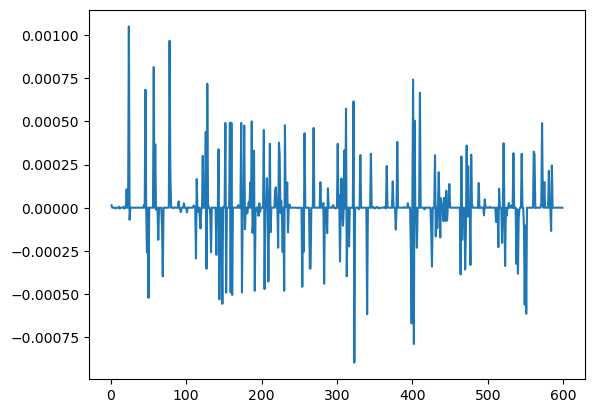

In [10]:
plt.plot(full_book_df[full_book_df["time_id"] == 5]['log_return'])

Now, we can implement the convolutional neural network. Since it's time-series data, we will use a 1-dimensional convolution. I'll use PyTorch. Below is a pretty standard neural network. A PyTorch neural network class must inherit from `nn.Module` and have a `forward` function. The `forward` function is what gets called when you want to predict with the neural network. You have essentially unlimited freedom in defining the forward function, it just has to use functions/operations which are in the PyTorch framework.

In [11]:
full_book_df.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap,log_return
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,1.001448,0.000014
2,5,2,1.001422,1.002301,1.00137,1.002353,3,100,2,100,1.001448,0.000000
3,5,3,1.001422,1.002301,1.00137,1.002353,3,100,2,100,1.001448,0.000000
4,5,4,1.001422,1.002301,1.00137,1.002353,3,100,2,100,1.001448,0.000000
5,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,1.001448,0.000000


In [12]:
class ConvNet(nn.Module):
    def __init__(self, hidden_width=64):
        super().__init__() # This is needed to initialize the class it inherits from
        self.activation = nn.ReLU()
        hidden_width=64
        self.conv1 = nn.Conv1d(in_channels=11, out_channels=hidden_width, kernel_size=3) # width 597
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2) # width 298
        self.conv2 = nn.Conv1d(in_channels=hidden_width, out_channels=hidden_width, kernel_size=3) # width 296
        # pool, width 148
        self.conv3 = nn.Conv1d(in_channels=hidden_width, out_channels=hidden_width, kernel_size=3) # width 146
        # pool, width 73
        self.conv4 = nn.Conv1d(in_channels=hidden_width, out_channels=hidden_width, kernel_size=3) # width 71
        # pool, width 35
        self.conv5 = nn.Conv1d(in_channels=hidden_width, out_channels=hidden_width, kernel_size=3) # width 33
        # pool, width 16
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=hidden_width*16, out_features=hidden_width*16) 
        self.linear2 = nn.Linear(in_features=hidden_width*16, out_features=hidden_width*16)
        self.linear3 = nn.Linear(in_features=hidden_width*16, out_features=1)
        

    def forward(self, x):
        out = self.conv1(x)
        out = self.pool(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.pool(out)
        out = self.activation(out)
        out = self.conv3(out)
        out = self.pool(out)
        out = self.activation(out)
        out = self.conv4(out)
        out = self.pool(out)
        out = self.activation(out)
        out = self.conv5(out)
        out = self.pool(out)
        out = self.activation(out)

        out = self.flatten(out)
        out = self.linear1(out)
        out = self.activation(out)
        out = self.linear2(out)
        out = self.activation(out)
        out = self.linear3(out)
        return out

Next, we need to split our data into a train and test split. We also need the data to be in tensors and not in dataframes.

In [13]:
data = torch.tensor(full_book_df.values).float() # the model is floating type by default
data = data.reshape(-1, 599, 12)
data = data.swapaxes(1, 2) # conv1d expects channels to come first
data = data[:, 2:, :] # drop time_id and seconds_in_bucket
# shape is (N, 10, 599)

# I am going to add the volatility. This would be more readable to do with a dataframe
vol = torch.sqrt(torch.sum(torch.square(data[:, 9:10, :]), axis=2, keepdim=True))
# expand the last dimension so we can append it to data
vol = vol.expand(-1, -1, 599)
# add it to data
data = torch.cat([data, vol], dim=1)

target = torch.tensor(target_df.values).float() 
target = target[:, 1:] # we don't want time_id

train_cutoff_index = int(.6*data.shape[0])
validation_cutoff_index = int(.8*data.shape[0])

train_data = data[:train_cutoff_index, :, :]
val_data = data[train_cutoff_index:validation_cutoff_index, :, :]
test_data = data[validation_cutoff_index:, :, :]

train_target = target[:train_cutoff_index, :]
val_target = target[train_cutoff_index:validation_cutoff_index, :]
test_target = target[validation_cutoff_index:, :]

Now, we can instantiate our neural network. We can make a dataloader to help with shuffling and batching the data.

In [14]:
model = ConvNet()

train_dataset = torch.utils.data.TensorDataset(train_data, train_target)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

Now, we are ready to actually train the model. We set up the optimizer and loss function, and initialize some data logging.

In [15]:
opt = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=.0001)

In [16]:

mse_loss = torch.nn.MSELoss()
epoch_counter = 0
loss_history = []
val_loss_history = []

Finally, we are ready to train the model. What follows is the standard training loop. This cell can be run more times to train more.

In [17]:
epochs = 1500
for _ in range(epochs):
    epoch_loss = 0
    for data, target in train_dataloader:
        opt.zero_grad()
        preds = model(data)
        loss = mse_loss(preds, target)
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
    loss_history.append(epoch_loss/len(train_dataloader))
    with torch.inference_mode():
        preds = model(val_data)
        val_loss = mse_loss(preds, val_target)
        val_loss_history.append(val_loss.item())
    epoch_counter += 1
    if epoch_counter == 1 or epoch_counter % 10 == 0:
        print(f"Epoch {epoch_counter:4d}, loss {loss_history[-1]:.9f}, validation loss {val_loss_history[-1]:.9f}")

Epoch    1, loss 0.032876513, validation loss 0.001226119
Epoch   10, loss 0.000062821, validation loss 0.000088533
Epoch   20, loss 0.000072552, validation loss 0.000061176
Epoch   30, loss 0.000017392, validation loss 0.000047339
Epoch   40, loss 0.000022571, validation loss 0.000041630
Epoch   50, loss 0.000022357, validation loss 0.000036152
Epoch   60, loss 0.000008342, validation loss 0.000030951
Epoch   70, loss 0.000010504, validation loss 0.000026899
Epoch   80, loss 0.000008556, validation loss 0.000024266
Epoch   90, loss 0.000012277, validation loss 0.000023332
Epoch  100, loss 0.000005235, validation loss 0.000018854
Epoch  110, loss 0.000004949, validation loss 0.000016559
Epoch  120, loss 0.000024896, validation loss 0.000019166
Epoch  130, loss 0.000004522, validation loss 0.000013952
Epoch  140, loss 0.000004676, validation loss 0.000013024
Epoch  150, loss 0.000005365, validation loss 0.000011667
Epoch  160, loss 0.000006661, validation loss 0.000012664
Epoch  170, lo

KeyboardInterrupt: 

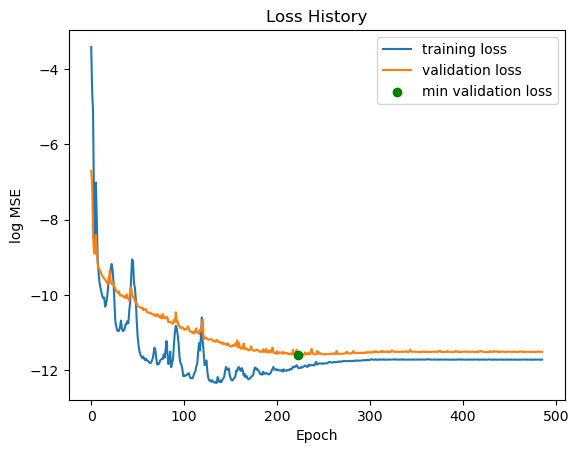

In [52]:
plt.plot(np.log(loss_history[:]), label='training loss')
plt.plot(np.log(val_loss_history[:]), label='validation loss')
min_loss_index = np.argmin(val_loss_history)
plt.scatter(min_loss_index, np.log(val_loss_history[min_loss_index]), c='g', zorder=2, label='min validation loss')
plt.xlabel("Epoch")
plt.ylabel("log MSE")
plt.legend()
plt.title("Loss History")
# plt.show()
plt.savefig('cnn_loss.png', dpi=300)

In [49]:
val_loss_history[220]

9.821140338317491e-06

Make predictions with the best model. We are getting the best estimator found by the grid search and using it to make predictions on the testing data.


In [53]:
predictions = model(test_data).detach().numpy()
measured_vol = test_data[:, -1, 0]

Calculate RMSE.


In [54]:
rmse = np.sqrt(mean_squared_error(test_target, predictions))
print("RMSE: ", rmse)

RMSE:  0.002534408


Calculate MAE.


In [55]:
mae = mean_absolute_error(test_target, predictions)
print("MAE: ", mae)

MAE:  0.0018257295


Calculate R-squared. This metric provides an indication of the goodness of fit of the model.


In [56]:
r2 = r2_score(test_target, predictions)
print("R-squared: ", r2)

R-squared:  -0.00013761770614606483
